# Shifting moons with dynamic rotation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dojax
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [4]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn

In [5]:
X, y = make_moons(n_samples=100, noise=0.12, random_state=314)

In [6]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(30)(x))
        x = nn.relu(nn.Dense(30, name="last_layer")(x))
        x = nn.Dense(1)(x)
        x = nn.sigmoid(x)
        return x

In [7]:
model = MLP()
loss = dojax.make_mse_func(model, X, y)

batch = jnp.ones((1, 2))
key = jax.random.PRNGKey(314)
params = model.init(key, batch)

alpha = 0.1
tx = optax.adam(learning_rate=alpha)

opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

In [8]:
for i in range(201):
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 50 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  0.09935955
Loss step 50:  0.00034957158
Loss step 100:  2.6696148e-06
Loss step 150:  5.7818403e-07
Loss step 200:  2.9943575e-07


## Multiple

In [100]:
def estimate_weights(model, X, y, key, optimizer, n_epochs=200, seed=None, output_progress=False, print_final_loss=False):
    loss = dojax.make_mse_func(model, X, y)
    batch = jnp.ones((1, 2))
    params = model.init(key, batch)
    opt_state = optimizer.init(params)
    loss_grad_fn = jax.value_and_grad(loss)
    
    for i in range(n_epochs):
        loss_val, grads = loss_grad_fn(params)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        if i % 50 == 0 and output_progress:
            print('Loss step {}: '.format(i), loss_val)
    if print_final_loss:
        print(f"Final loss: {loss_val}")
    
    return params

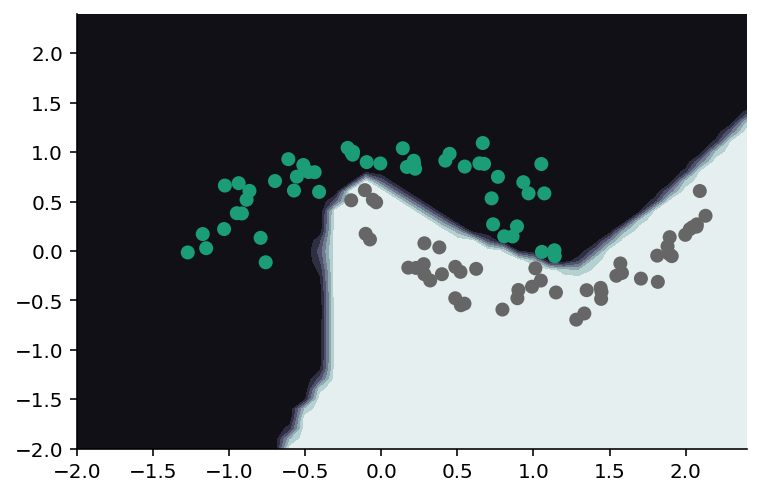

In [13]:
model = MLP()
alpha = 0.1
tx = optax.adam(learning_rate=alpha)

X, y = make_moons(n_samples=100, noise=0.12, random_state=314)
X = jnp.einsum("nm,mk->nk", X, dojax.rotation_matrix(0))
params = estimate_weights(model, X, y, key, tx)
params_flat, _ = jax.flatten_util.ravel_pytree(params)

pred_map = jax.vmap(model.apply, (None, 1))
pred_map = jax.vmap(pred_map, (None, 2))

X_grid = jnp.mgrid[-2:2.5:0.1, -2:2.5:0.1]
Z = jnp.einsum("ijn->ji", pred_map(params, X_grid))

plt.contourf(*X_grid, Z, cmap="bone")
plt.scatter(*X.T, c=y, cmap="Dark2")

## Weight's dynamics

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [22]:
n_samples = 100
n_steps = 100

model = MLP()
alpha = 0.05
tx = optax.adam(learning_rate=alpha)

D_hist = []
weights_hist = jnp.zeros(len(params_flat), dtype=float)[None, :]
all_weights_hist = []


for it, rad in enumerate(jnp.linspace(0, 2 * jnp.pi, n_steps)):
    print(f"@{it=} | rad={rad * 180:0.0f}", end="\r")
    X, y = make_moons(n_samples=n_samples, noise=0.12, random_state=314 + it)
    
    X = jnp.einsum("nm,mk->nk", X, dojax.rotation_matrix(rad))
    
    
    params = estimate_weights(model, X, y, key, tx)
    
    params_flat, _ = jax.flatten_util.ravel_pytree(params)
    weights_hist = jnp.concatenate([weights_hist, params_flat[None, :]], axis=0)
    all_weights_hist.append(params)
    D_hist.append((jnp.c_[X, y]))
    
weights_hist = weights_hist[1:]
D_hist = jnp.stack(D_hist, axis=0)

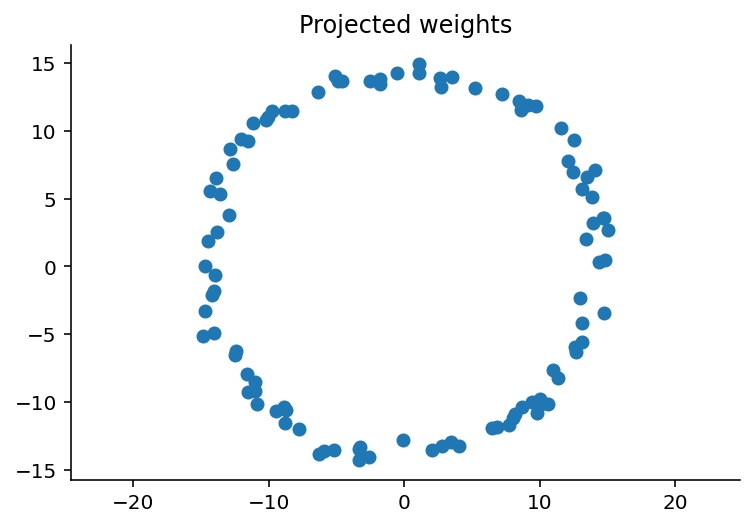

In [16]:
pca = PCA(n_components=2)
w_transformed = pca.fit_transform(weights_hist)

plt.title("Projected weights")
plt.scatter(*w_transformed.T)
plt.axis("equal");

In [19]:
D_hist.shape

(100, 100, 3)

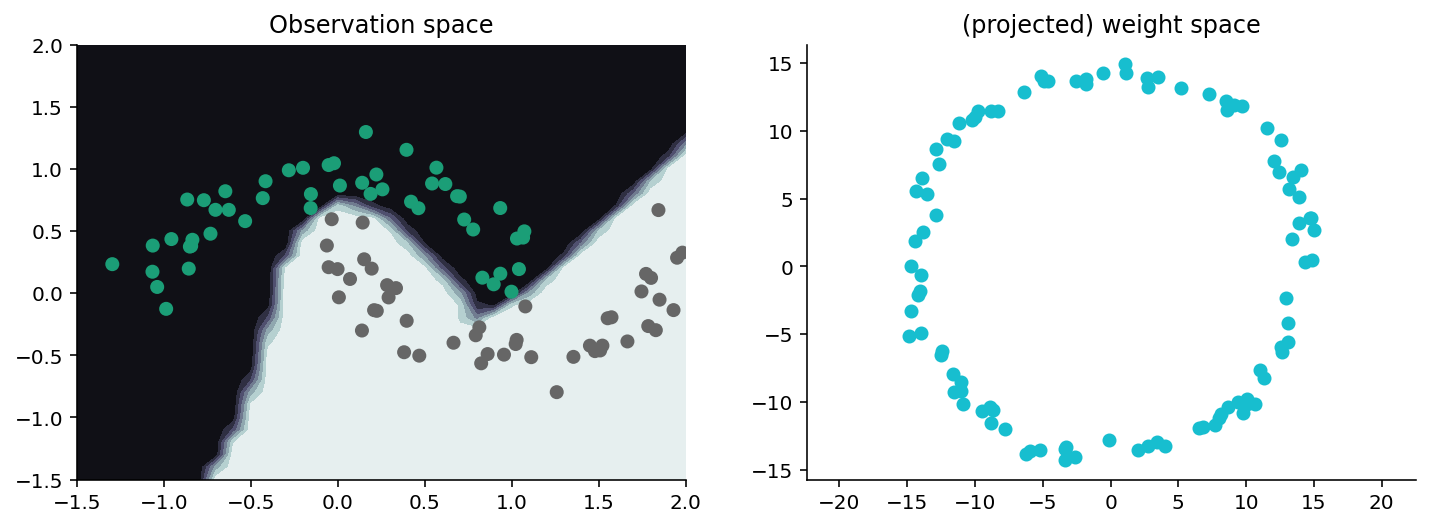

In [87]:
from celluloid import Camera

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
camera = Camera(fig)

ax[0].set_title("Observation space")
ax[1].set_title("(projected) weight space")
for it in range(n_steps):
    # plt.cla()
    params = all_weights_hist[it]
    X_step, y_step = D_hist[it, :, :-1], D_hist[it, :, -1]
    Z = jnp.einsum("ijn->ji", pred_map(params, X_grid))
    
    ax[1].scatter(*w_transformed[:it].T, c="tab:cyan")
    ax[1].axis("equal")
    ax[0].contourf(*X_grid, Z, cmap="bone")
    ax[0].scatter(*X_step.T, c=y_step, cmap="Dark2")
    ax[0].set_xlim(-1.5, 2)
    ax[0].set_ylim(-1.5, 2)
    camera.snap()

animation = camera.animate()  
# animation.save('half-moons.gif', writer = 'imagemagick')
animation.save('half-moons.mp4', fps=20, dpi=150)

## Second try

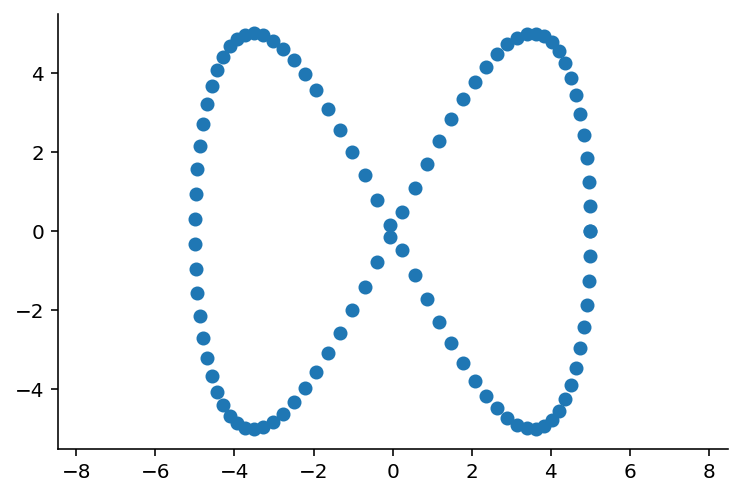

In [88]:
for r in jnp.linspace(0, 2 * jnp.pi, 100):
    x = 5 * jnp.cos(r)
    y = 5 * jnp.sin(2 * r)
    plt.scatter(x, y, c="tab:blue")
plt.axis("equal");

In [107]:
model = MLP()
alpha = 0.01
tx = optax.adam(learning_rate=alpha)
n_steps = 200

D_hist = []
weights_hist = jnp.zeros(len(params_flat), dtype=float)[None, :]
all_weights_hist = []


# two turns around
rads = jnp.linspace(0, 2 * 2 * jnp.pi, n_steps)
for it, rad in enumerate(rads):
    print(f"@{it=} | rad={rad * 180:0.0f}")
    X, y = make_moons(n_samples=100, noise=0.12, random_state=314 + it)
    
    X = jnp.einsum("nm,mk->nk", X, dojax.rotation_matrix(rad))
    X = X + 3 * jnp.c_[jnp.cos(rad), jnp.sin(2 * rad)]
    
    params = estimate_weights(model, X, y, key, tx, n_epochs=1_500, print_final_loss=True)
    
    params_flat, _ = jax.flatten_util.ravel_pytree(params)
    weights_hist = jnp.concatenate([weights_hist, params_flat[None, :]], axis=0)

    all_weights_hist.append(params)
    D_hist.append((jnp.c_[X, y]))
    
weights_hist = weights_hist[1:]
D_hist = jnp.stack(D_hist, axis=0)

@it=0 | rad=0
Final loss: 0.04615980386734009
@it=1 | rad=11
Final loss: 0.04335566237568855
@it=2 | rad=23
Final loss: 5.8479847211856395e-05
@it=3 | rad=34
Final loss: 0.040898654609918594
@it=4 | rad=45
Final loss: 3.549292159732431e-05
@it=5 | rad=57
Final loss: 2.4380004106205888e-05
@it=6 | rad=68
Final loss: 2.4454846425214782e-05
@it=7 | rad=80
Final loss: 2.448890700179618e-05
@it=8 | rad=91
Final loss: 4.460716445464641e-05
@it=9 | rad=102
Final loss: 3.8829006371088326e-05
@it=10 | rad=114
Final loss: 2.3081274775904603e-05
@it=11 | rad=125
Final loss: 8.394203177886084e-06
@it=12 | rad=136
Final loss: 0.06803692877292633
@it=13 | rad=148
Final loss: 1.5581224943161942e-05
@it=14 | rad=159
Final loss: 1.150342450273456e-05
@it=15 | rad=170
Final loss: 7.436906344082672e-06
@it=16 | rad=182
Final loss: 5.493739081430249e-06
@it=17 | rad=193
Final loss: 8.243166121246759e-06
@it=18 | rad=205
Final loss: 4.445228114491329e-06
@it=19 | rad=216
Final loss: 2.6342322598793544e-06


/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


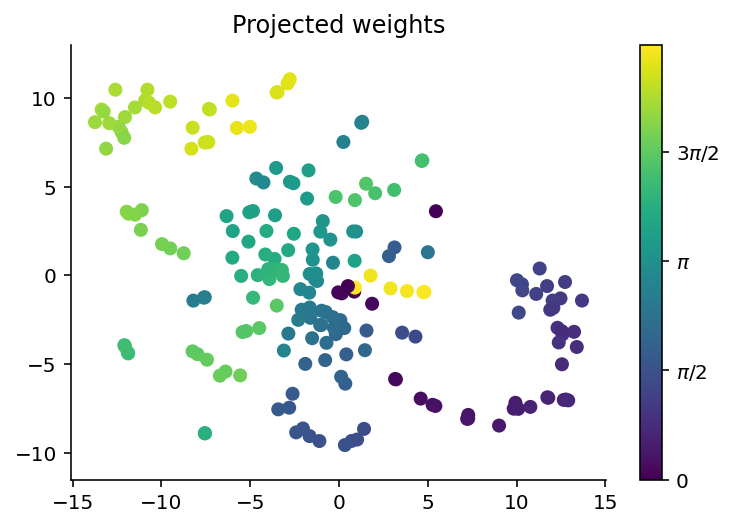

In [120]:
# proj = PCA(n_components=2)
proj = TSNE(init="pca", learning_rate="auto", random_state=314)
w_transformed = proj.fit_transform(weights_hist)

plt.title("Projected weights")
plt.scatter(*w_transformed.T, c=rads % (2 * jnp.pi))

cticks = jnp.arange(0, jnp.pi * 2 + jnp.pi/2, jnp.pi / 2)
cbar = plt.colorbar(ticks=cticks)
cbar.ax.set_yticklabels(["0", "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"])

plt.axis("equal");

In [121]:
deg_hist=rads % (2 * jnp.pi)

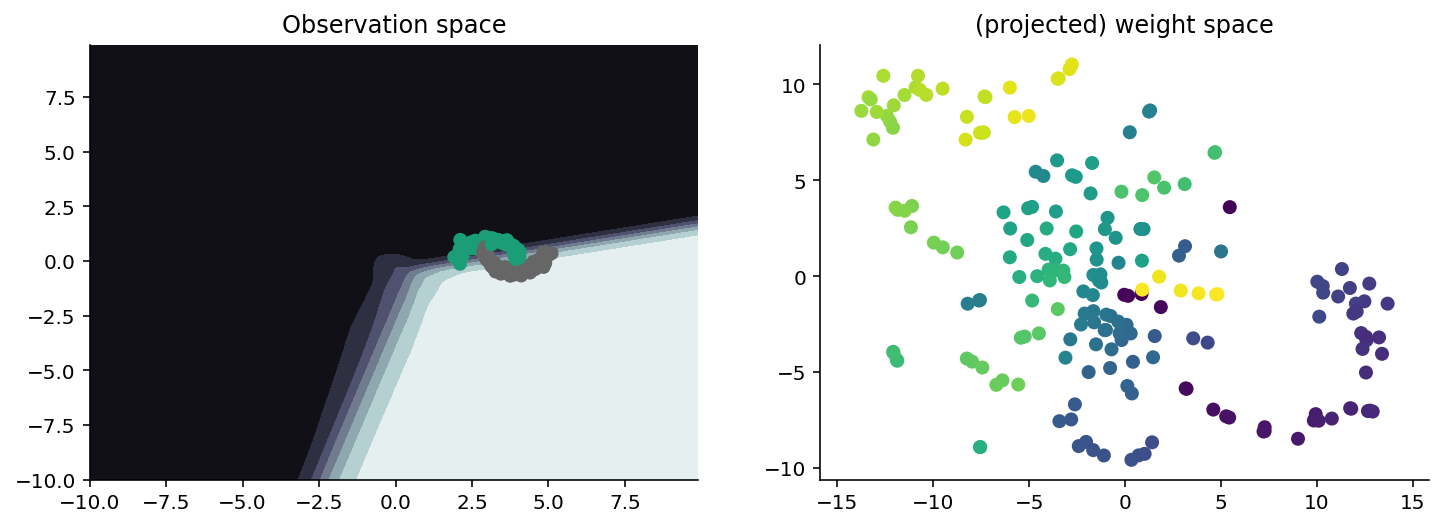

In [122]:
from celluloid import Camera

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
camera = Camera(fig)

X_grid = jnp.mgrid[-10:10:0.1, -10:10:0.1]
ax[0].set_title("Observation space")
ax[1].set_title("(projected) weight space")
for it in range(n_steps):
    # plt.cla()
    params = all_weights_hist[it]
    X_step, y_step = D_hist[it, :, :-1], D_hist[it, :, -1]
    Z = jnp.einsum("ijn->ji", pred_map(params, X_grid))
    
    ax[1].scatter(*w_transformed[:it].T, c=deg_hist[:it])
    ax[1].axis("equal")
    ax[0].contourf(*X_grid, Z, cmap="bone")
    ax[0].scatter(*X_step.T, c=y_step, cmap="Dark2")
    # ax[0].set_xlim(-1.5, 2)
    # ax[0].set_ylim(-1.5, 2)
    camera.snap()

animation = camera.animate()  
# animation.save('half-moons.gif', writer = 'imagemagick')
animation.save('half-moons-shifted.mp4', fps=20, dpi=150)

* Distance in weight space.
* We can track distribution shift through the weights of NNet if the transformation is smooth.
* Neural generative models. Take VAE => Apply weights to the VAE.
* Conjectures: Neural architectures preserve the topology of the weight-space dynamics.
* Q: how to make the predictions? / how to choose the learned weights?

## ToDo

1. Dimensionality
2. Stochasticity
3. Abrupt changes

# * Increase dimensionality of points (20D/40D)
* Nonlinear transformation of points

1. Try transformation over MNIST dataset
2. Try _topological_ transformation of the moons to two circles. (Try transformation with discretised ODEs)
3. Abrupt change of relabeling of points.